
**Note on the Use of Techniques in this Notebook:**

Throughout this notebook, a variety of techniques and methodologies have been applied to the dataset for exploratory and analytical purposes. It's important to understand that not all techniques are universally suitable for every dataset. The choice of technique should ideally be based on the nature of the data, the underlying distribution, and the specific goals of the analysis.

- Some techniques may be computationally intensive and might not be feasible for very large datasets without significant computational resources.

The reason for showcasing a range of techniques in this notebook is to demonstrate familiarity and proficiency with them. In a real-world scenario, one would select techniques after careful consideration of the dataset's characteristics and the analysis's objectives.


In [2]:
! huggingface-cli login



    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) y
Token is valid (permission: read).
Cannot authenticate through git-cr

In [3]:
pip install datasets


In [4]:
from datasets import load_dataset

dataset = load_dataset("beans")

In [4]:
dataset.keys()

dict_keys(['train', 'validation', 'test'])

In [5]:
dataset['train'][0].keys()

dict_keys(['image_file_path', 'image', 'labels'])

## Understanding data Structure

In [6]:
from PIL import Image
import numpy as np

print("# of class:", len(dataset['train'].features['labels'].names))
print("# of train img:", len(dataset['train']))

widths, heights = [], []

for data in dataset['train']:
    with Image.open(data['image_file_path']) as img:
        width, height = img.size
        widths.append(width)
        heights.append(height)
print("avg width:", np.mean(widths))
print("ave height:", np.mean(heights))

# of class: 3
# of train img: 1034
avg width: 500.0
ave height: 500.0


## Data Visualization

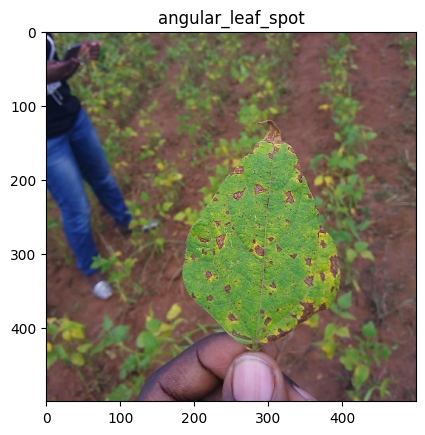

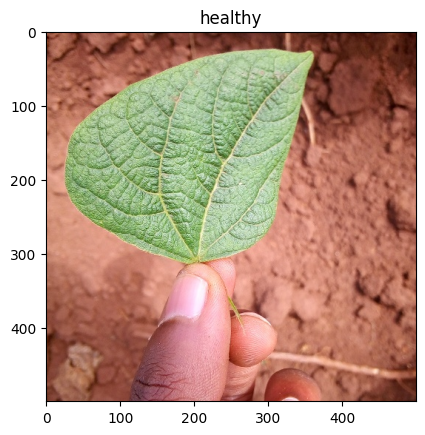

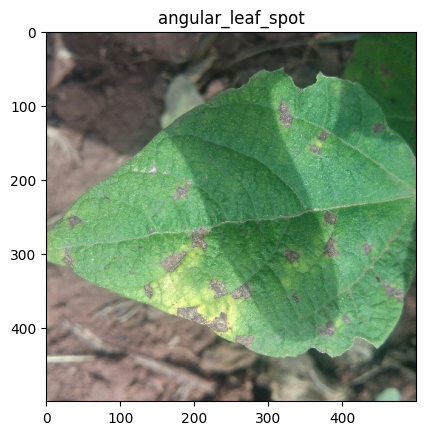

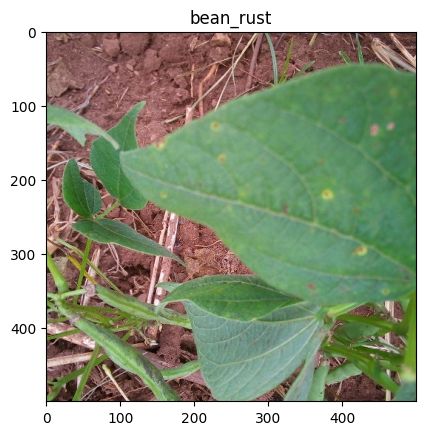

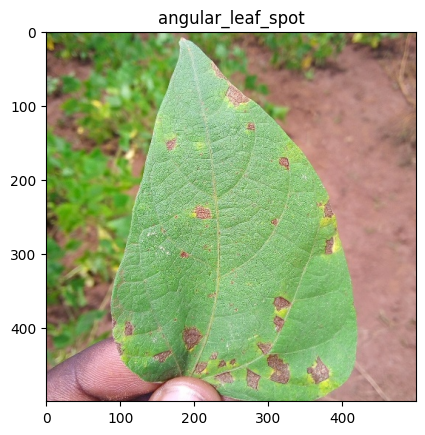

In [9]:
import matplotlib.pyplot as plt
from PIL import Image

sample_data = dataset['train'].shuffle().select(range(5))
for data in sample_data:
    image = Image.open(data['image_file_path'])
    label = dataset['train'].features['labels'].names[data['labels']]



    plt.imshow(image)
    plt.title(label)
    plt.show()


## Class Distribution

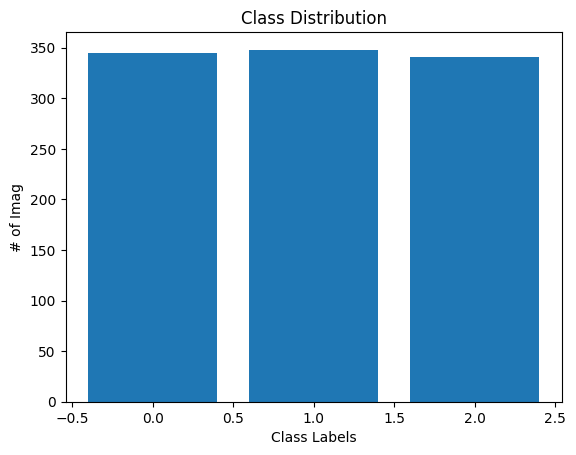

In [10]:
import numpy as np


labels = [data['labels'] for data in dataset['train']]
unique, counts = np.unique(labels, return_counts=True)



plt.bar(unique, counts)
plt.title("Class Distribution")
plt.xlabel("Class Labels")
plt.ylabel("# of Imag")
plt.show()


## Image Augmentation

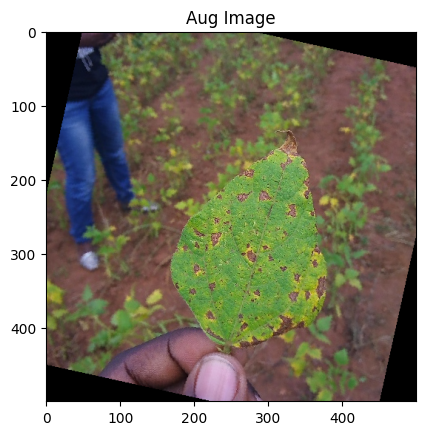

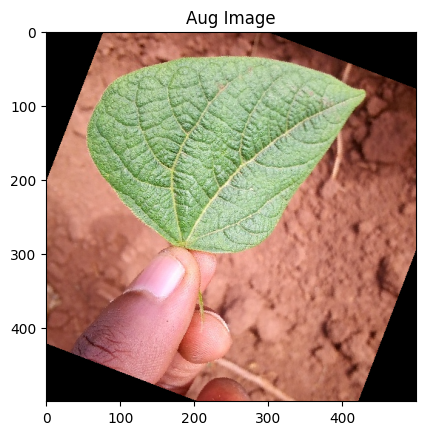

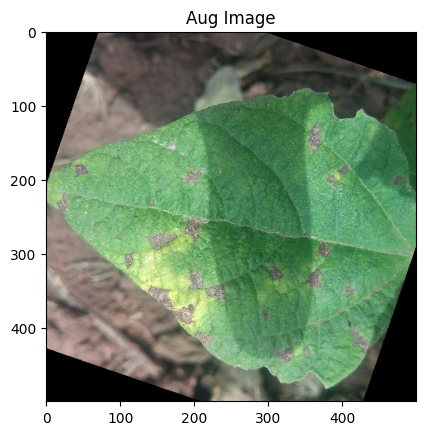

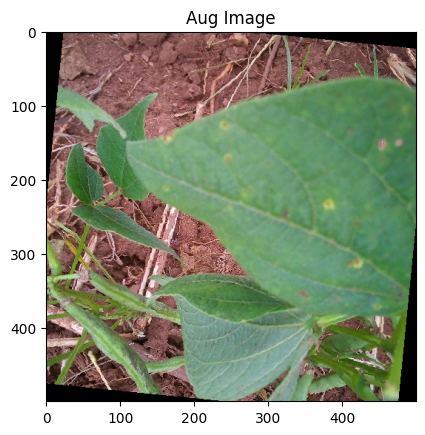

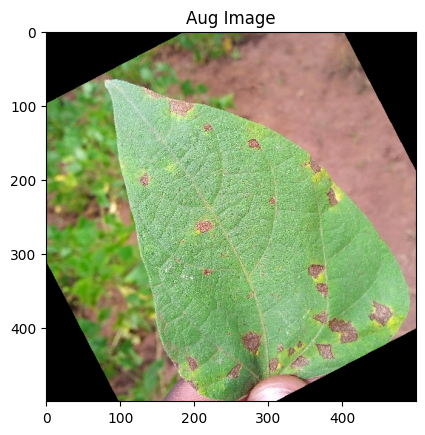

In [11]:
from torchvision.transforms import RandomRotation

transform = RandomRotation(30)

for data in sample_data:
    image = Image.open(data['image_file_path'])
    augmented_image = transform(image)
    plt.imshow(augmented_image)
    plt.title("Aug Image")
    plt.show()


## feature distribution

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


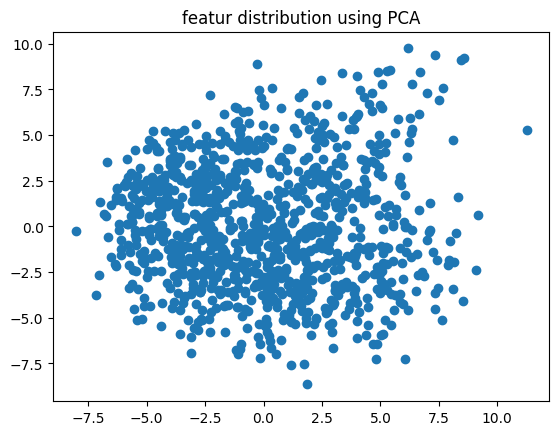

In [13]:
import torch
import torchvision.transforms as transforms
from torchvision.models import resnet50
from sklearn.decomposition import PCA
from PIL import Image
import matplotlib.pyplot as plt


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = resnet50(pretrained=True).to(device)
model = torch.nn.Sequential(*(list(model.children())[:-1])).eval()



transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])



features = []
for data in dataset['train']:
    image = Image.open(data['image_file_path']).convert('RGB')
    tensor = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        feature = model(tensor)
    features.append(feature.cpu().squeeze().numpy())



pca = PCA(n_components=2)
reduced_features = pca.fit_transform(features)
plt.scatter(reduced_features[:, 0], reduced_features[:, 1])
plt.title("featur distribution using PCA")
plt.show()

# Feature Extraction

In [7]:
import torch
import torchvision.transforms as transforms
from torchvision.models import resnet50
from tqdm.notebook import tqdm



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = resnet50(pretrained=True).to(device)
model = torch.nn.Sequential(*(list(model.children())[:-1])).eval()



transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])



features = []

for data in tqdm(dataset['train']):
    image = Image.open(data['image_file_path']).convert('RGB')
    tensor = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        feature = model(tensor)
    features.append(feature.cpu().squeeze().numpy())

features = np.array(features)
print("Extracted features shape:", features.shape)


  0%|          | 0/1034 [00:00<?, ?it/s]

Extracted features shape: (1034, 2048)


## find duplicate images

In [13]:
!pip install imagehash

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 4.9 MB/s eta 0:00:00


In [14]:
import imagehash


hashes = {}
duplicates = []



for data in dataset['train']:
    image = Image.open(data['image_file_path']).convert('RGB')
    h = imagehash.phash(image)
    if h in hashes:
        duplicates.append((data['image_file_path'], hashes[h]))
    else:
        hashes[h] = data['image_file_path']


print(f"Found {len(duplicates)} duplicate pairs.")
for pair in duplicates:
    print("duplicate pair:", pair)

Found 0 duplicate pairs.


## Histogram

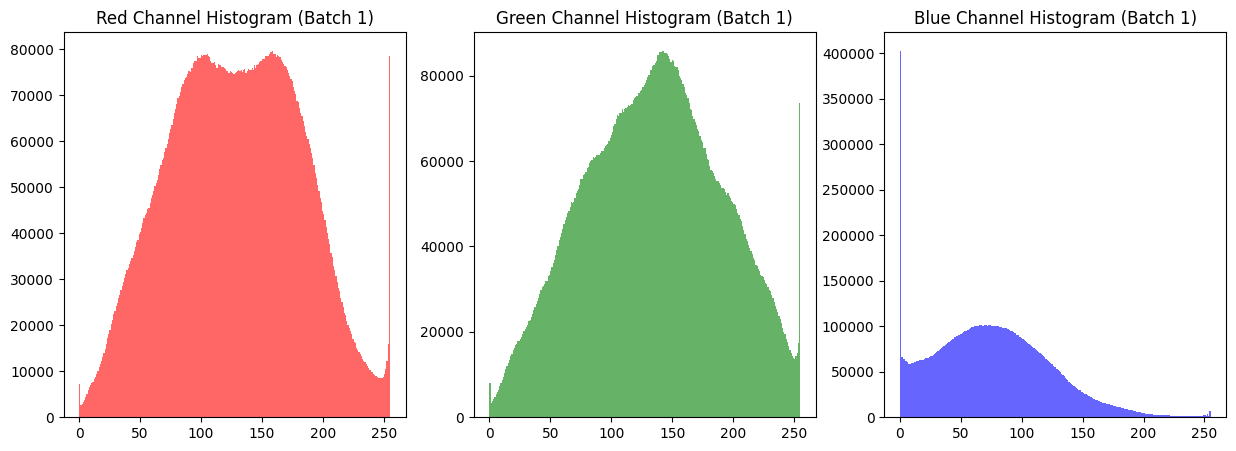

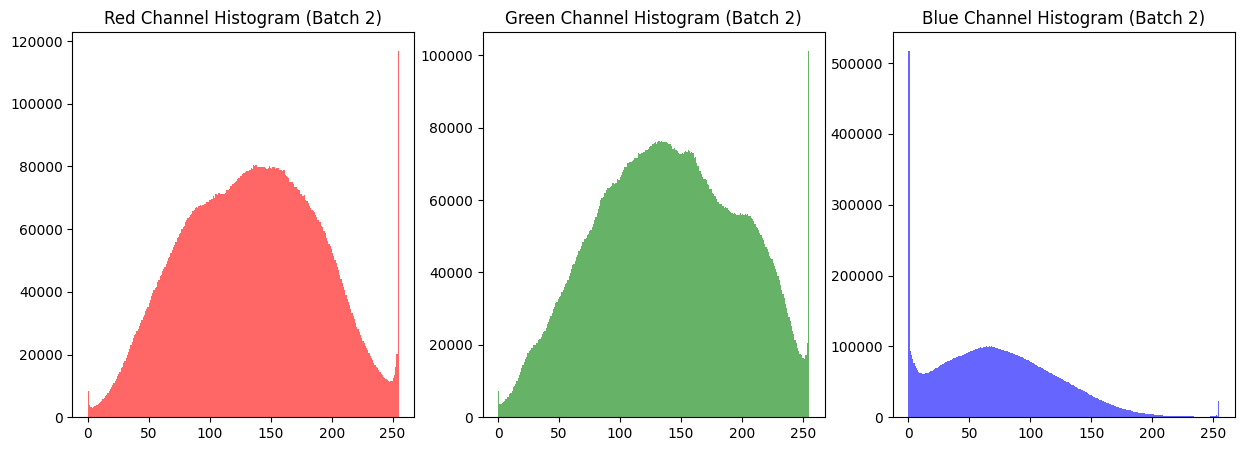

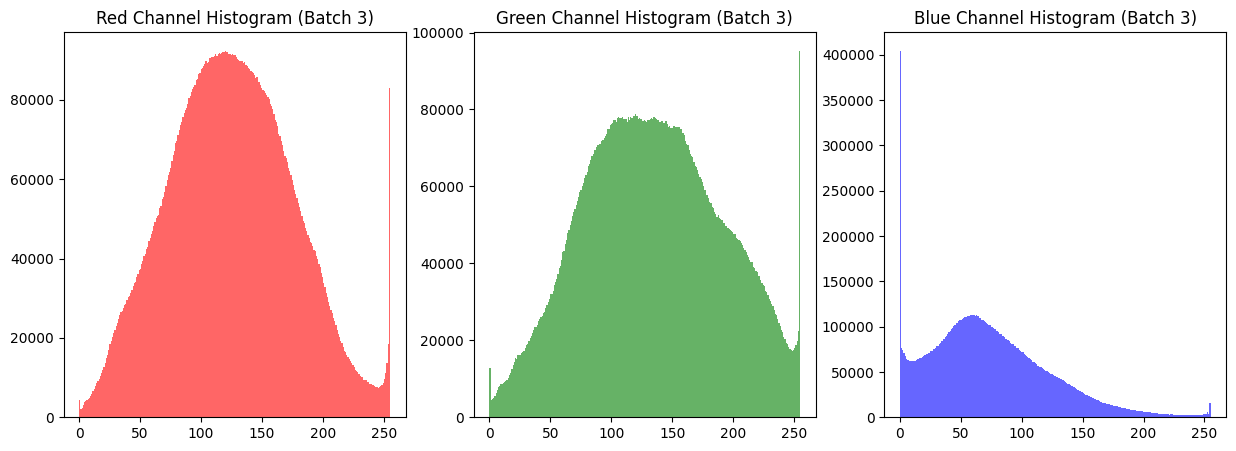

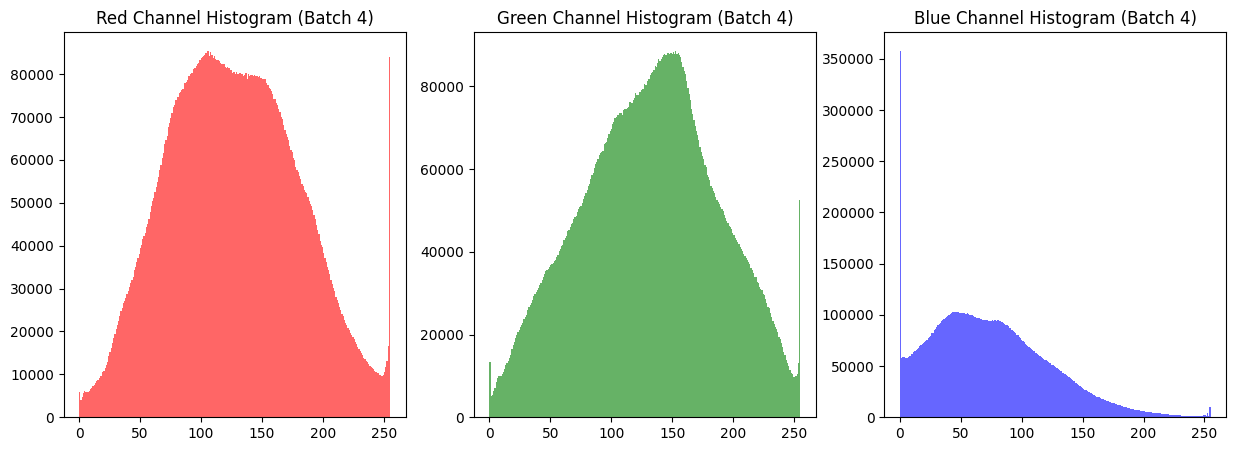

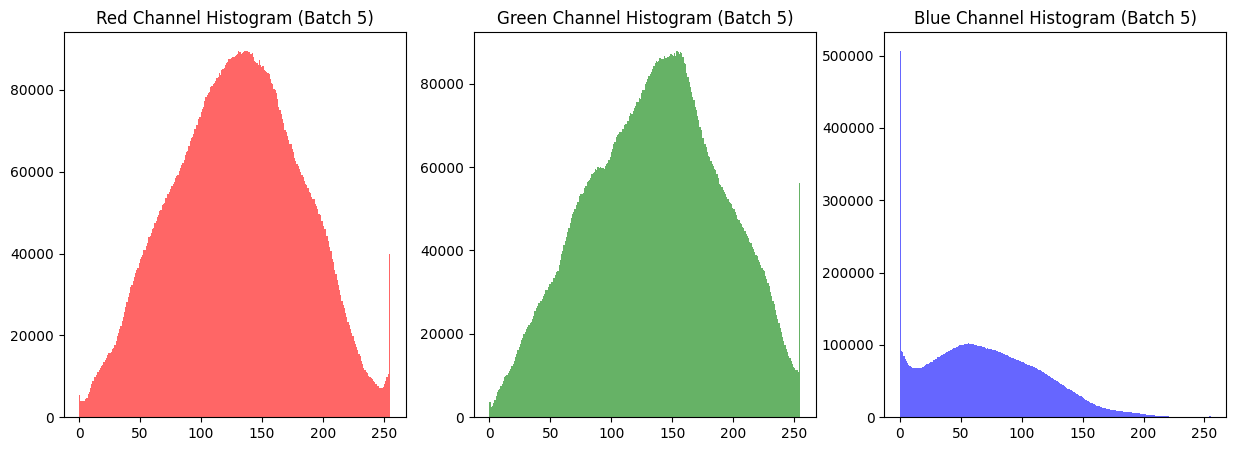

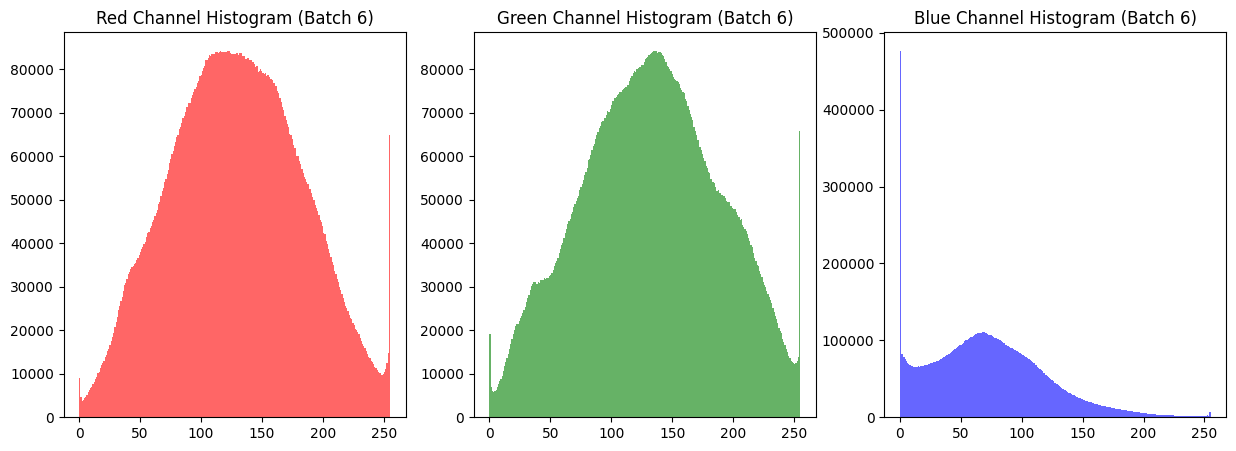

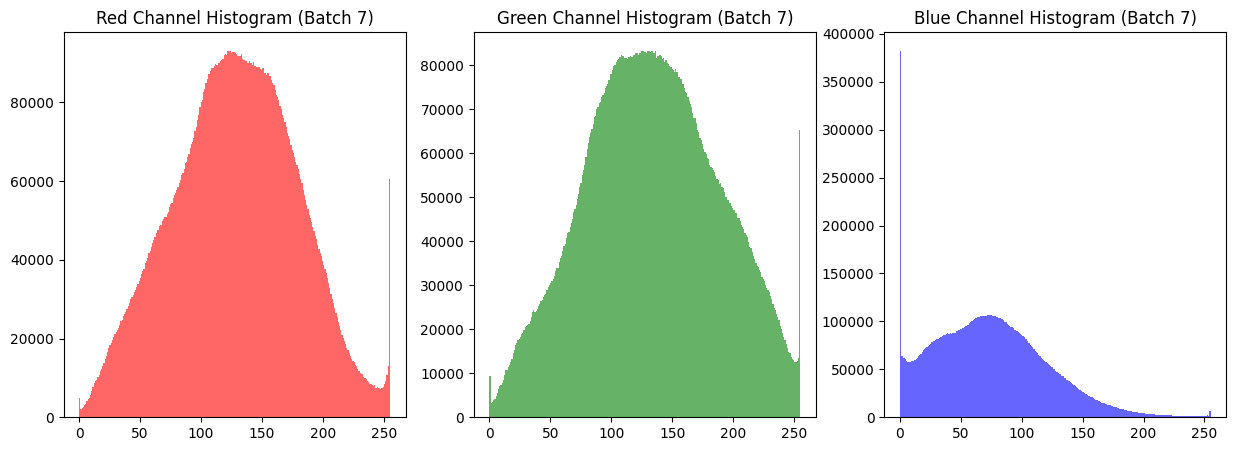

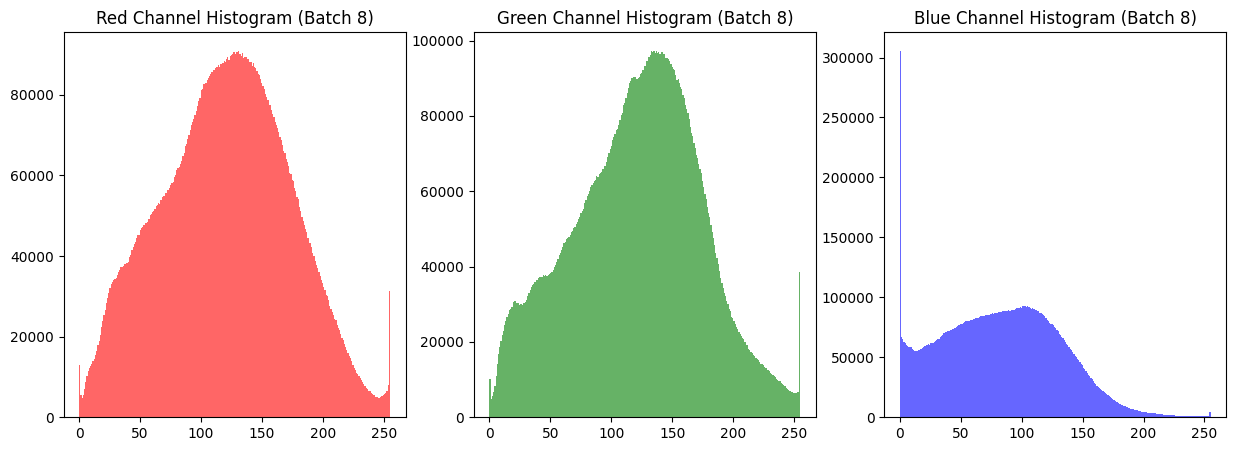

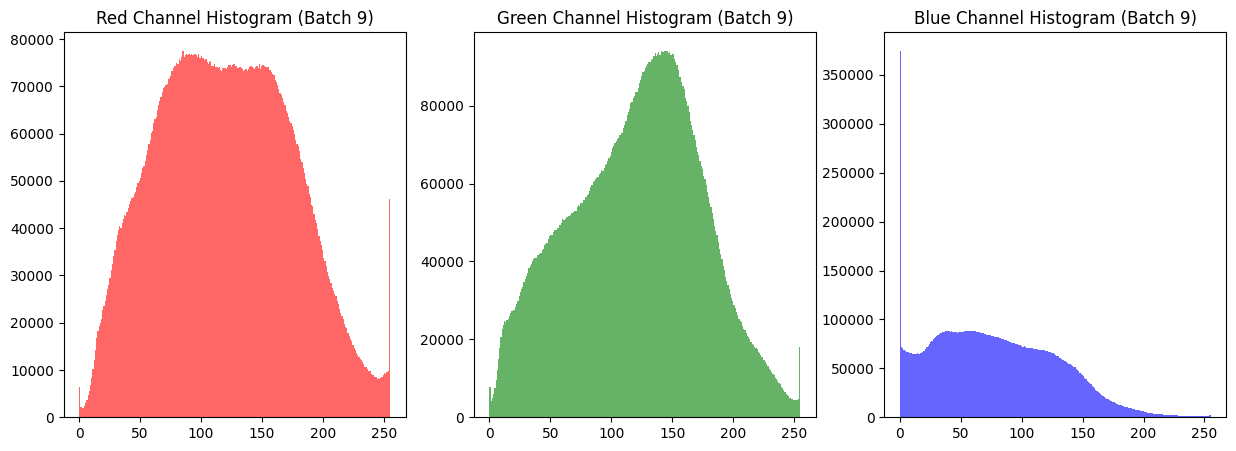

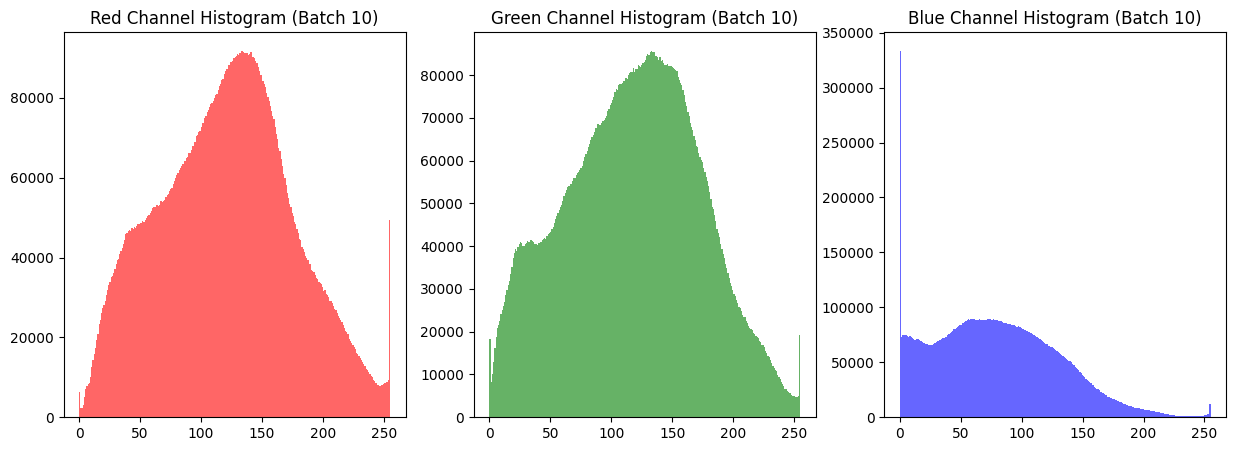

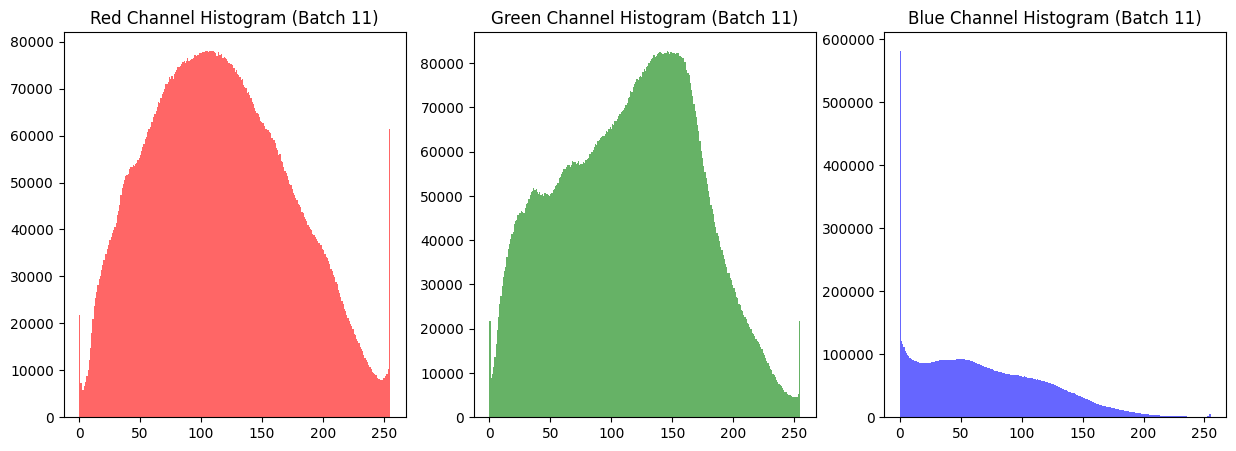

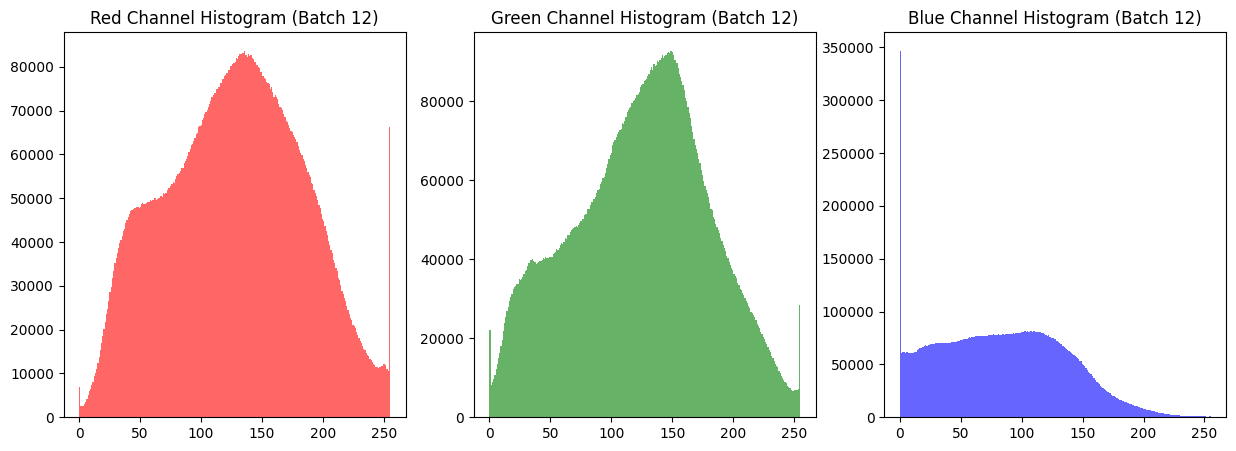

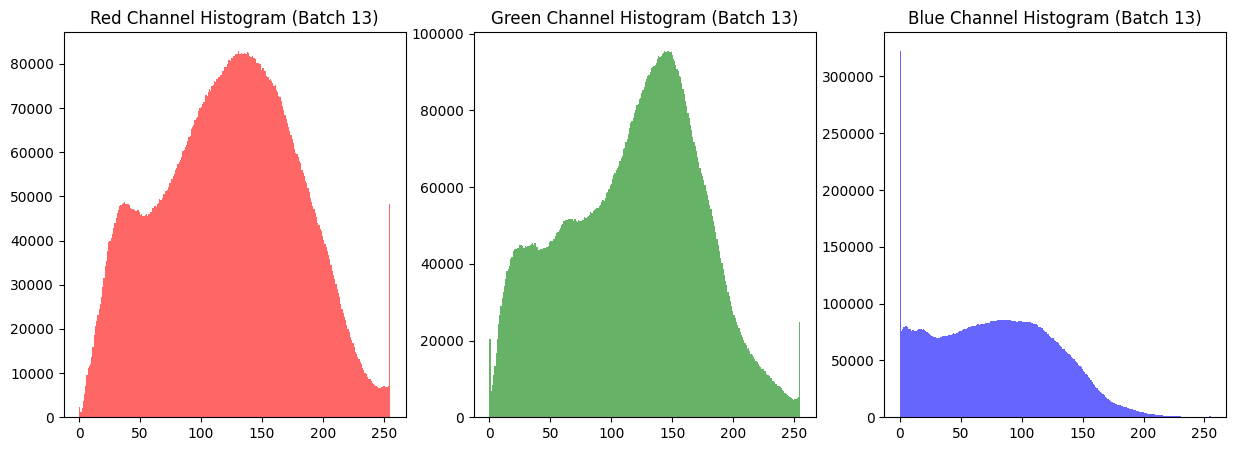

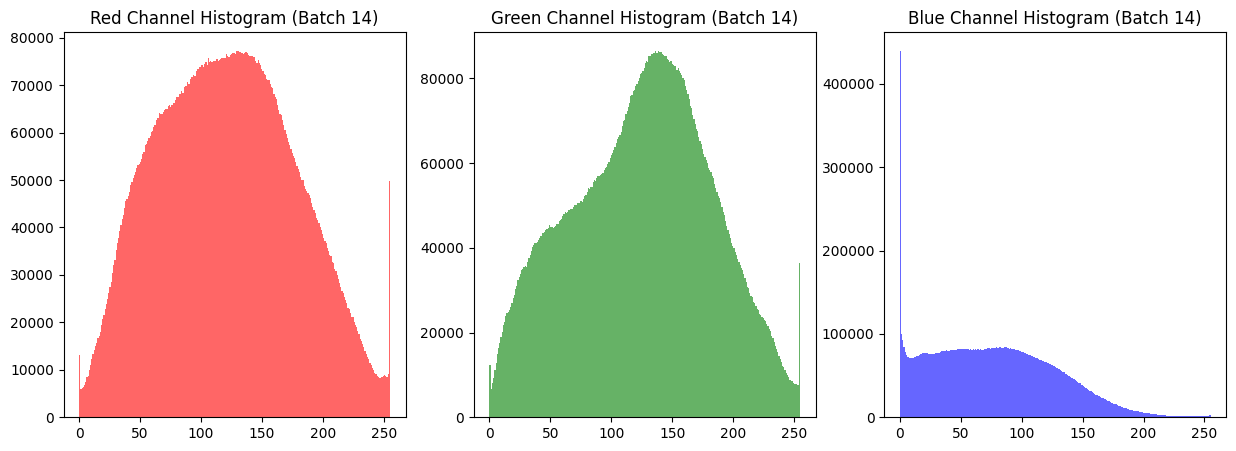

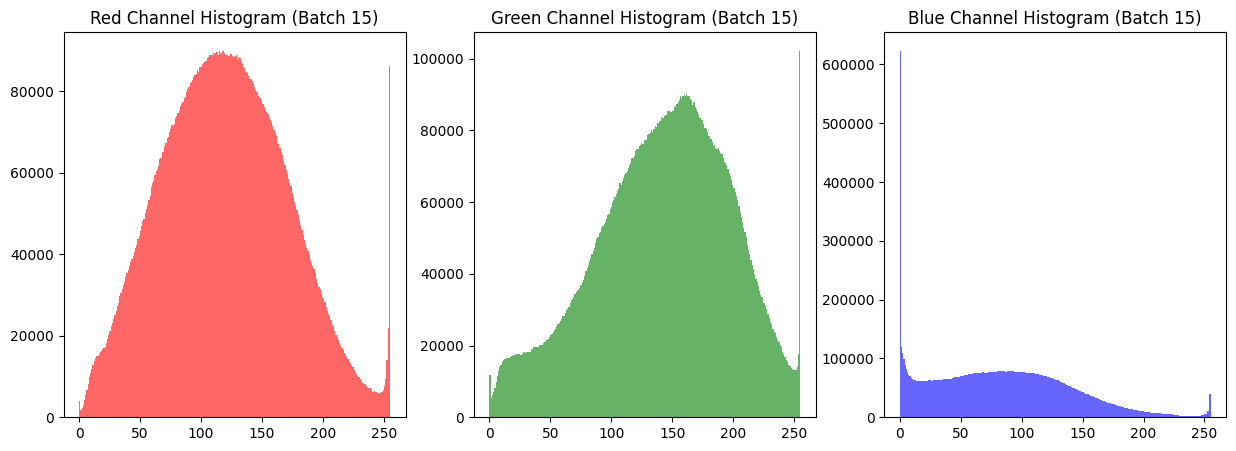

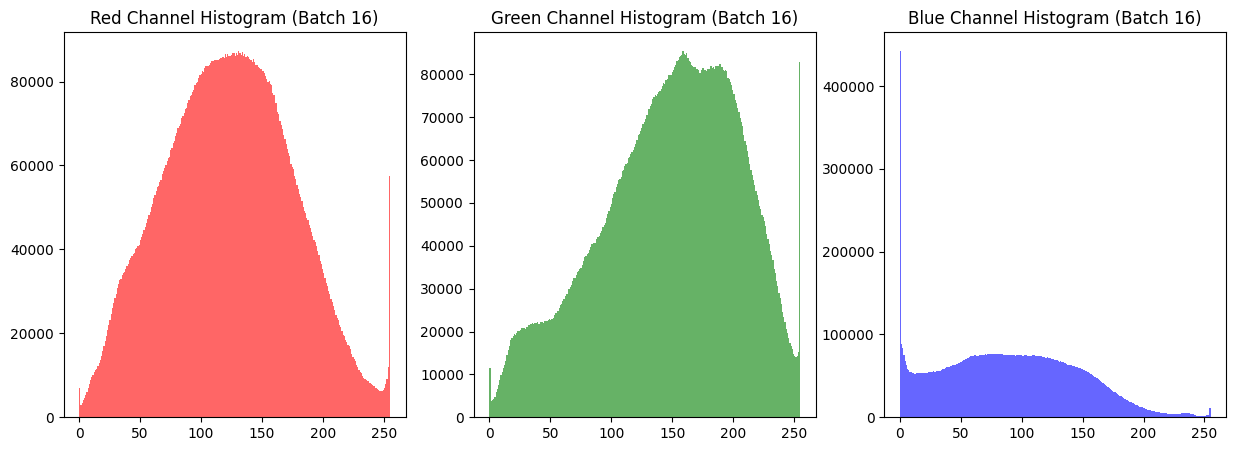

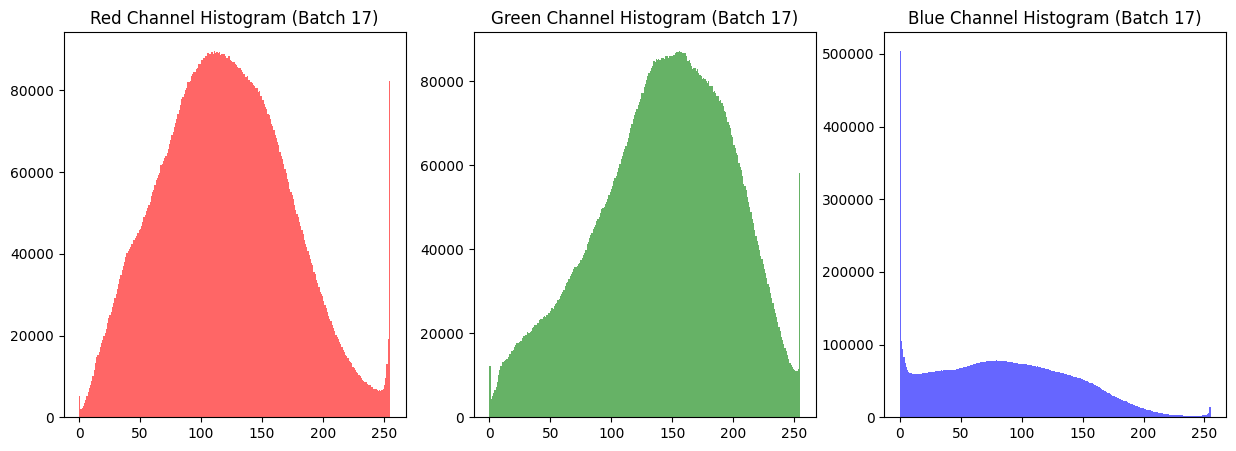

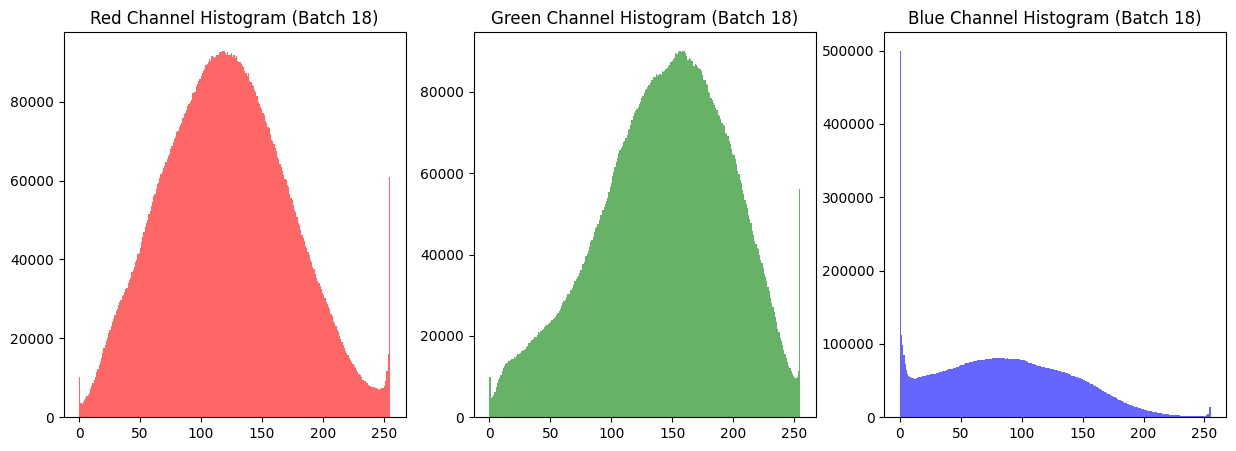

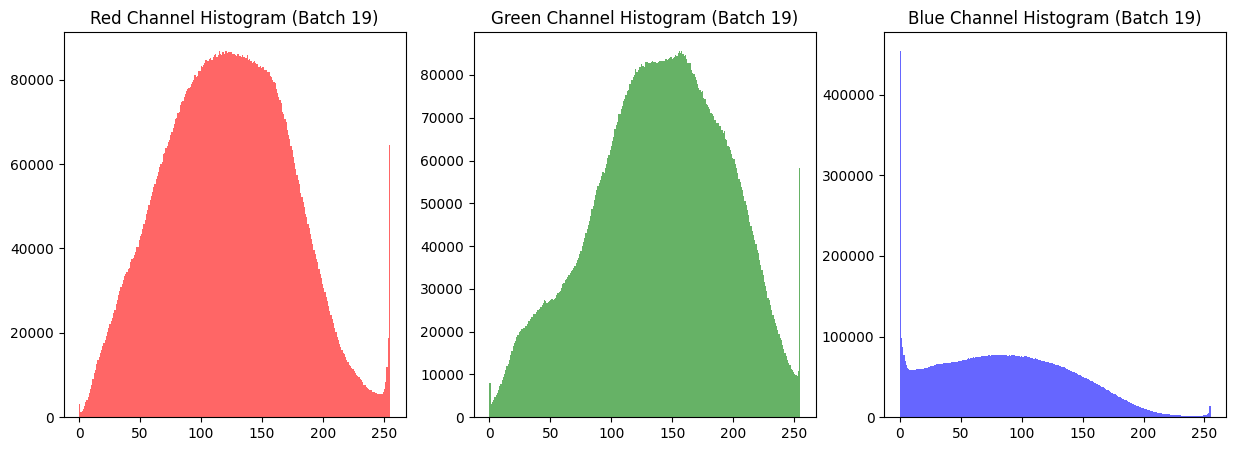

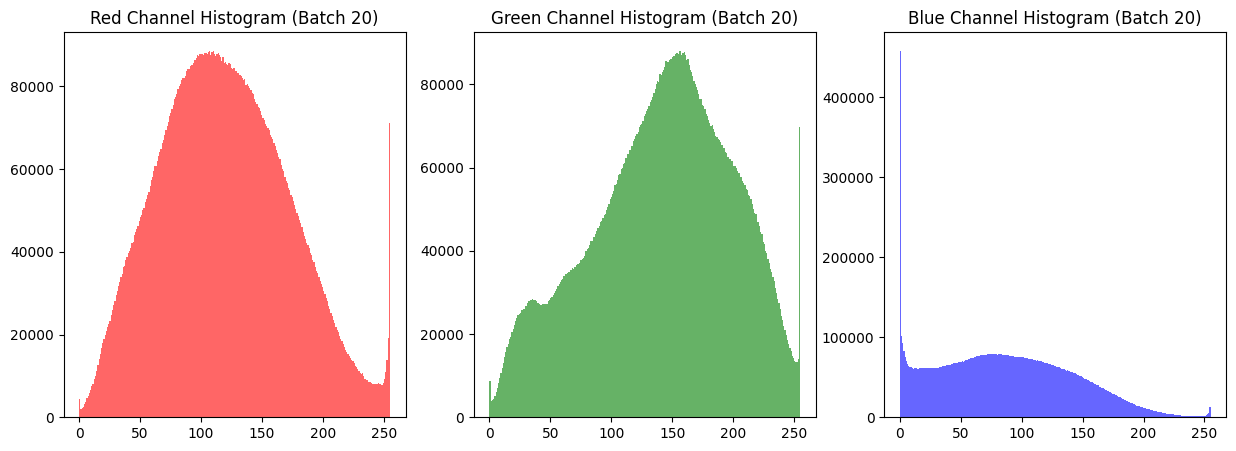

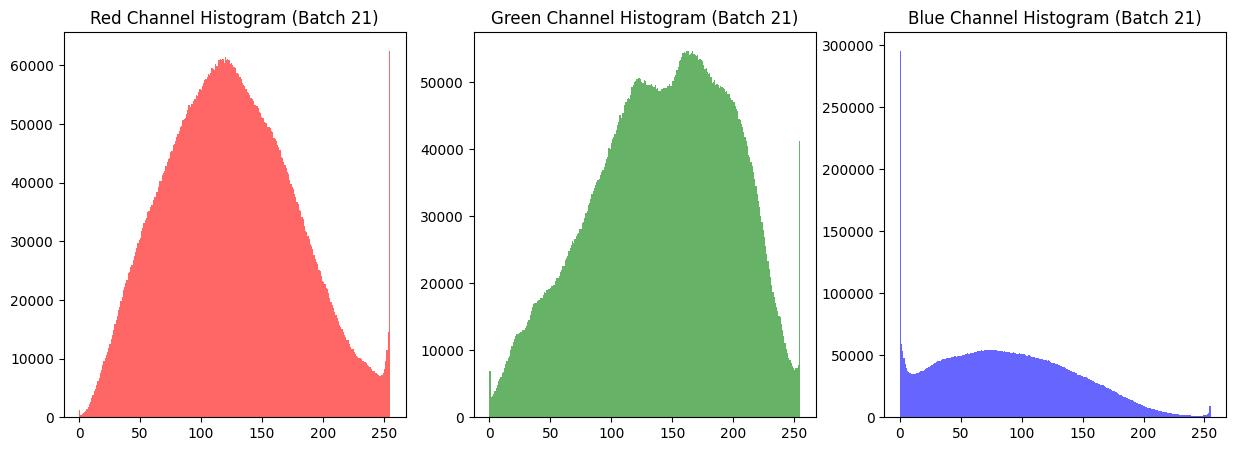

In [16]:
def batched_pixel_histogram(dataset, batch_size=50):
    for i in range(0, len(dataset['train']), batch_size):
        r_values = []
        g_values = []
        b_values = []

        batch_indices = list(range(i, min(i + batch_size, len(dataset['train']))))
        batch = dataset['train'].select(batch_indices)

        for data in batch:
            image = Image.open(data['image_file_path'])
            r, g, b = image.split()
            r_values.extend(list(r.getdata()))
            g_values.extend(list(g.getdata()))
            b_values.extend(list(b.getdata()))

        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.hist(r_values, bins=256, color='red', alpha=0.6)
        plt.title(f'Red Channel Histogram (Batch {i//batch_size + 1})')

        plt.subplot(1, 3, 2)
        plt.hist(g_values, bins=256, color='green', alpha=0.6)
        plt.title(f'Green Channel Histogram (Batch {i//batch_size + 1})')

        plt.subplot(1, 3, 3)
        plt.hist(b_values, bins=256, color='blue', alpha=0.6)
        plt.title(f'Blue Channel Histogram (Batch {i//batch_size + 1})')

        plt.show()

batched_pixel_histogram(dataset)


## Class Feature Wise

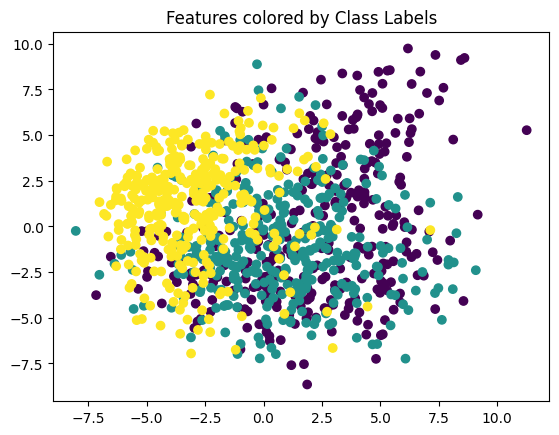

In [14]:
labels = [data['labels'] for data in dataset['train']]
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=labels, cmap='viridis')
plt.title("Features colored by Class Labels")
plt.show()


## Feature Clustring

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


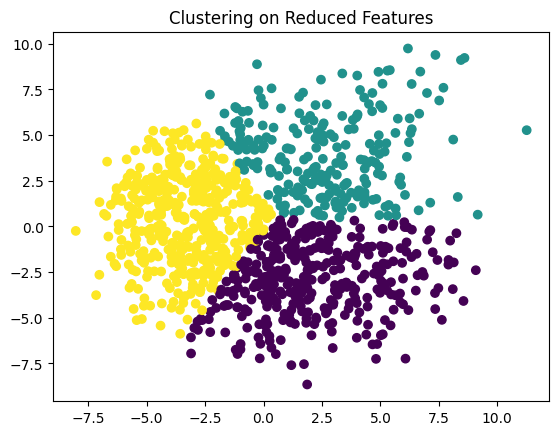

In [15]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3)
cluster_labels = kmeans.fit_predict(reduced_features)

plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=cluster_labels)
plt.title("Clustering on Reduced Features")
plt.show()


## image quality

In [12]:
import cv2

def check_blur(image_path):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return cv2.Laplacian(gray, cv2.CV_64F).var()

blur_values = [check_blur(data['image_file_path']) for data in dataset['train']]
threshold = 100
num_blurry = sum([1 for v in blur_values if v < threshold])

print(f"Number of potentially blurry images: {num_blurry}")

Number of potentially blurry images: 0
